In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import nc_time_axis

from cartopy.util import add_cyclic_point

from cartopy import crs as ccrs
from datetime import datetime
import pandas as pd
import cartopy
import cartopy.feature as cfeature
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr
from skill_metrics import taylor_statistics, taylor_diagram
import skill_metrics as sm
from matplotlib.lines import Line2D
from matplotlib.patches import Arc

/var/folders/r2/7vgy_x_x70gd4nm39slmcz640000gn/T/ipykernel_87357/3063896309.py:14: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
var_list = 'salt_ex_c_vs emiss salt aer_ex_c_vs t_surf u v wind rlut rsdt rsut sulfate_ex_c_vs sm_dst_ex_c_vs lg_dst_ex_c_vs blk_crb_ex_c_vs org_crb_ex_c_vs'.split()


In [6]:
gong = {}
for var in var_list:
    if var == 'v':
        gong[var] = xr.concat([xr.open_mfdataset(f"/Users/cindywang/Desktop/Thesis_3/AM4/gong/{var}/*.nc", parallel=True,decode_cf=True)],dim = "bnds").isel(bnds=0)['v_ref']
        gong[var] = xr.where(gong[var] < -1e7, float("nan"),gong[var])
    elif var == 'u':
        gong[var] = xr.concat([xr.open_mfdataset(f"/Users/cindywang/Desktop/Thesis_3/AM4/gong/{var}/*.nc", parallel=True,decode_cf=True)],dim = "bnds").isel(bnds=0)['u_ref']
        gong[var] = xr.where(gong[var] < -1e7, float("nan"),gong[var])
    elif var == "wind":
        gong[var] = (gong['u']**2 + gong['v']**2)**0.5
    else:
        gong[var] = xr.concat([xr.open_mfdataset(f"/Users/cindywang/Desktop/Thesis_3/AM4/gong/{var}/*.nc", parallel=True,decode_cf=True)],dim = "bnds").isel(bnds=0)[var]




In [7]:
jaegle = {}
for var in var_list:
    if var == 'v':
        jaegle[var] = xr.concat([xr.open_mfdataset(f"/Users/cindywang/Desktop/Thesis_3/AM4/jaegle/{var}/*.nc", parallel=True,decode_cf=True)],dim = "bnds").isel(bnds=0)['v_ref']
        jaegle[var] = xr.where(jaegle[var] < -1e7, float("nan"),jaegle[var])
    elif var == 'u':
        jaegle[var] = xr.concat([xr.open_mfdataset(f"/Users/cindywang/Desktop/Thesis_3/AM4/jaegle/{var}/*.nc", parallel=True,decode_cf=True)],dim = "bnds").isel(bnds=0)['u_ref']
        jaegle[var] = xr.where(jaegle[var] < -1e7, float("nan"),jaegle[var])
    elif var == "wind":
        jaegle[var] = (jaegle['u']**2 + jaegle['v']**2)**0.5
    else:
        jaegle[var] = xr.concat([xr.open_mfdataset(f"/Users/cindywang/Desktop/Thesis_3/AM4/jaegle/{var}/*.nc", parallel=True,decode_cf=True)],dim = "bnds").isel(bnds=0)[var]


In [8]:
martmon = {}
for var in var_list:
    if var == 'v':
        martmon[var] = xr.concat([xr.open_mfdataset(f"/Users/cindywang/Desktop/Thesis_3/AM4/martmon/{var}/*.nc", parallel=True,decode_cf=True)],dim = "bnds").isel(bnds=0)['v_ref']
        martmon[var] = xr.where(martmon[var] < -1e7, float("nan"),martmon[var])
    elif var == 'u':
        martmon[var] = xr.concat([xr.open_mfdataset(f"/Users/cindywang/Desktop/Thesis_3/AM4/martmon/{var}/*.nc", parallel=True,decode_cf=True)],dim = "bnds").isel(bnds=0)['u_ref']
        martmon[var] = xr.where(martmon[var] < -1e7, float("nan"),martmon[var])
    elif var == "wind":
        martmon[var] = (martmon['u']**2 + martmon['v']**2)**0.5
    else:
        martmon[var] = xr.concat([xr.open_mfdataset(f"/Users/cindywang/Desktop/Thesis_3/AM4/martmon/{var}/*.nc", parallel=True,decode_cf=True)],dim = "bnds").isel(bnds=0)[var]


In [9]:
deike = {}
for var in var_list:
    if var == 'v':
        deike[var] = xr.concat([xr.open_mfdataset(f"/Users/cindywang/Desktop/Thesis_3/AM4/deike/{var}/*.nc", parallel=True,decode_cf=True)],dim = "bnds").isel(bnds=0)['v_ref']
        deike[var] = xr.where(deike[var] < -1e7, float("nan"),deike[var])
    elif var == 'u':
        deike[var] = xr.concat([xr.open_mfdataset(f"/Users/cindywang/Desktop/Thesis_3/AM4/deike/{var}/*.nc", parallel=True,decode_cf=True)],dim = "bnds").isel(bnds=0)['u_ref']
        deike[var] = xr.where(deike[var] < -1e7, float("nan"),deike[var])
    elif var == "wind":
        deike[var] = (deike['u']**2 + deike['v']**2)**0.5
    else:
        deike[var] = xr.concat([xr.open_mfdataset(f"/Users/cindywang/Desktop/Thesis_3/AM4/deike/{var}/*.nc", parallel=True,decode_cf=True)],dim = "bnds").isel(bnds=0)[var]


In [10]:
def global_mean_xarray(ds_XXLL):
    """ 
    Compute the global mean value of the data.
    The data has to have the lat and lon in its dimensions.
    Should not include NaN in Inputs.
    
    Parameters
    ----------
    ds_XXLL   : xarray with lat and lon. ds_XXLL.lat will be 
                used for area weight.

    Returns
    ----------
    tmp_XX    : xarray without lat and lon.
    
    """
    lat = ds_XXLL.coords['lat']        # readin lat
    # global mean
    # compute cos(lat) as a weight function
    weight_lat = np.cos(np.deg2rad(lat))/np.mean(np.cos(np.deg2rad(lat)))
    tmp_XXL = ds_XXLL.mean(dim=['lon'])*weight_lat
    tmp_XX  = tmp_XXL.mean(dim=['lat'])
    return tmp_XX

def global_sum_xarray(ds_XXLL):
    """ 
    Compute the global mean value of the data.
    The data has to have the lat and lon in its dimensions.
    Should not include NaN in Inputs.
    
    Parameters
    ----------
    ds_XXLL   : xarray with lat and lon. ds_XXLL.lat will be 
                used for area weight.

    Returns
    ----------
    tmp_XX    : xarray without lat and lon.
    
    """
    lat = ds_XXLL.coords['lat']        # readin lat
    # global mean
    # compute cos(lat) as a weight function
    weight_lat = np.cos(np.deg2rad(lat))/np.mean(np.cos(np.deg2rad(lat)))
    tmp_XXL = ds_XXLL.sum(dim=['lon'])*weight_lat
    tmp_XX  = tmp_XXL.sum(dim=['lat'])
    return tmp_XX

def weighted_temporal_mean_l(ds, var=None):
    """
    weight by days in each month
    """
    #ds = xr.decode_cf(ds)
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds if var is None else ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [11]:
AERONET_climo = xr.open_mfdataset(f"./aerosol_data/aeronet_v3_l2_solar_monthly_clim_2020.nc", parallel=True,decode_cf=True)['AOD_mth_mean']
AERONET_climo_sd = xr.open_mfdataset(f"./aerosol_data/aeronet_v3_l2_solar_monthly_clim_2020.nc", parallel=True,decode_cf=True)['AOD_clim_mth_std']


In [12]:
AERONET_climo_mm = AERONET_climo[:,4,:,9:-1].mean("year")

In [13]:
AERONET_write_climo = xr.Dataset()
AERONET_write_climo.coords['month'] = (('month'),AERONET_climo.coords['month'].values)
AERONET_write_climo.coords['lon'] = (('lon'),xr.open_mfdataset(f"./aerosol_data/aeronet_v3_l2_solar_monthly_clim_2020.nc", parallel=True,decode_cf=True)['stat_lon']
.values)
AERONET_write_climo.coords['stat'] = (('stat'),xr.open_mfdataset(f"./aerosol_data/aeronet_v3_l2_solar_monthly_clim_2020.nc", parallel=True,decode_cf=True)['stat']
.values)
AERONET_write_climo.coords['lat'] = (('lat'),xr.open_mfdataset(f"./aerosol_data/aeronet_v3_l2_solar_monthly_clim_2020.nc", parallel=True,decode_cf=True)['stat_lat']
.values)
AERONET_write_climo['climo_mm'] = (('stat','month'),AERONET_climo_mm.values)

AERONET_write_climo['deike'] = (('stat','month'),xr.open_mfdataset(f"./aerosol_data/aeronet_v3_l2_solar_monthly_clim_2020.nc", parallel=True,decode_cf=True)['AOD_clim_mth_mean'][:,4,:]
.values)
AERONET_write_climo['gong'] = (('stat','month'),xr.open_mfdataset(f"./aerosol_data/aeronet_v3_l2_solar_monthly_clim_2020.nc", parallel=True,decode_cf=True)['AOD_clim_mth_mean'][:,4,:]
.values)
AERONET_write_climo['jaegle'] = (('stat','month'),xr.open_mfdataset(f"./aerosol_data/aeronet_v3_l2_solar_monthly_clim_2020.nc", parallel=True,decode_cf=True)['AOD_clim_mth_mean'][:,4,:]
.values)
AERONET_write_climo['martmon'] = (('stat','month'),xr.open_mfdataset(f"./aerosol_data/aeronet_v3_l2_solar_monthly_clim_2020.nc", parallel=True,decode_cf=True)['AOD_clim_mth_mean'][:,4,:]
.values)

In [14]:
def convert_longitude(lon):
    return ((lon + 180) % 360) - 180

In [15]:
deike['aer_ex_c_vs'] = deike['aer_ex_c_vs'].assign_coords(lon = convert_longitude(deike['aer_ex_c_vs'].lon))#[240:]
jaegle['aer_ex_c_vs'] = jaegle['aer_ex_c_vs'].assign_coords(lon = convert_longitude(jaegle['aer_ex_c_vs'].lon))#[240:]
gong['aer_ex_c_vs'] = gong['aer_ex_c_vs'].assign_coords(lon = convert_longitude(gong['aer_ex_c_vs'].lon))#[240:]
martmon['aer_ex_c_vs'] = martmon['aer_ex_c_vs'].assign_coords(lon = convert_longitude(martmon['aer_ex_c_vs'].lon))#[240:]


In [16]:
jaegle['aer_ex_c_vs'] = jaegle['aer_ex_c_vs'].sortby(jaegle['aer_ex_c_vs'].lon)
deike['aer_ex_c_vs'] = deike['aer_ex_c_vs'].sortby(deike['aer_ex_c_vs'].lon)
gong['aer_ex_c_vs'] = gong['aer_ex_c_vs'].sortby(gong['aer_ex_c_vs'].lon)
martmon['aer_ex_c_vs'] = martmon['aer_ex_c_vs'].sortby(martmon['aer_ex_c_vs'].lon)


In [17]:
da = deike['aer_ex_c_vs'].groupby('time.month').mean(dim='time')
lon_values = AERONET_write_climo['lon'].values
lat_values = AERONET_write_climo['lat'].values

min_diff_index_lon = np.zeros(516)
min_diff_index_lat = np.zeros(516)


In [18]:
for i in np.arange(516):
    abs_diff = np.abs(da.lon - lon_values[i])
    min_diff_index_lon[i] = np.array(np.unravel_index(np.argmin(abs_diff.values), abs_diff.shape))
        
    abs_diff = np.abs(da.lat - lat_values[i])
    min_diff_index_lat[i] = np.array(np.unravel_index(np.argmin(abs_diff.values), abs_diff.shape))
        #AERONET_write_climo['deike'][i,:] = da[:,min_diff_index_lat,min_diff_index_lon].squeeze()


In [19]:
for i in np.arange(516):
    AERONET_write_climo['deike'][i,:] = da[:,np.int(min_diff_index_lat[i]),np.int(min_diff_index_lon[i])]
    AERONET_write_climo['gong'][i,:] = gong['aer_ex_c_vs'].groupby('time.month').mean(dim='time')[:,np.int(min_diff_index_lat[i]),np.int(min_diff_index_lon[i])]
    AERONET_write_climo['jaegle'][i,:] = jaegle['aer_ex_c_vs'].groupby('time.month').mean(dim='time')[:,np.int(min_diff_index_lat[i]),np.int(min_diff_index_lon[i])]
    AERONET_write_climo['martmon'][i,:] = martmon['aer_ex_c_vs'].groupby('time.month').mean(dim='time')[:,np.int(min_diff_index_lat[i]),np.int(min_diff_index_lon[i])]
    

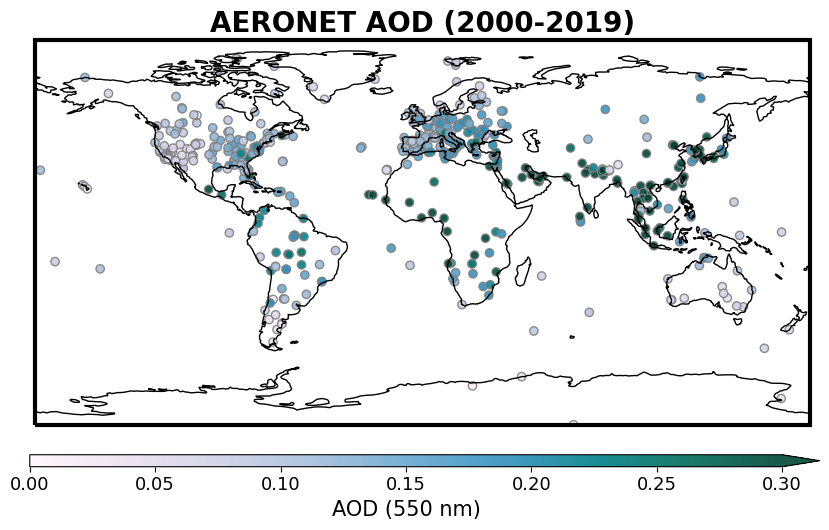

In [19]:
fig, axs = plt.subplots(1,1,figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})


axs.coastlines()
sc = axs.scatter(AERONET_write_climo.lon,AERONET_write_climo.lat,c = AERONET_write_climo.climo_mm.mean("month"), cmap='PuBuGn', alpha=0.9, vmin=0, vmax=0.3,edgecolors='gray')
axs.set_title('AERONET AOD (2000-2019)',fontsize =20,fontweight="bold")
[i.set_linewidth(3) for i in axs.spines.values()];

cax = fig.add_axes([0.12, axs.get_position().y0-0.07, 0.79, 0.02])
cbar = plt.colorbar(sc, cax=cax, orientation='horizontal', extend='max')
cbar.set_label('AOD (550 nm)', fontsize = 15)
cbar.ax.tick_params(labelsize=13) 

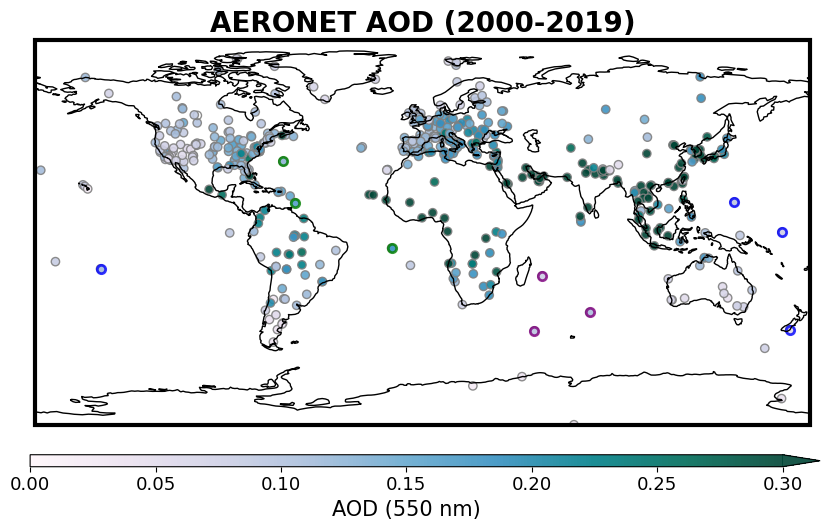

In [21]:
fig, axs = plt.subplots(1,1,figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})


axs.coastlines()
sc = axs.scatter(AERONET_write_climo.lon,AERONET_write_climo.lat,c = AERONET_write_climo.climo_mm.mean("month"), cmap='PuBuGn', alpha=0.9, vmin=0, vmax=0.3,edgecolors='gray')
axs.set_title('AERONET AOD (2000-2019)',fontsize =20,fontweight="bold")
[i.set_linewidth(3) for i in axs.spines.values()];

cax = fig.add_axes([0.12, axs.get_position().y0-0.07, 0.79, 0.02])
cbar = plt.colorbar(sc, cax=cax, orientation='horizontal', extend='max')
cbar.set_label('AOD (550 nm)', fontsize = 15)
cbar.ax.tick_params(labelsize=13) 

sc = axs.scatter(AERONET_write_climo.lon[175],AERONET_write_climo.lat[175],c = AERONET_write_climo.climo_mm.mean("month")[175],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='b', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[318],AERONET_write_climo.lat[318],c = AERONET_write_climo.climo_mm.mean("month")[318],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='b', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[443],AERONET_write_climo.lat[443],c = AERONET_write_climo.climo_mm.mean("month")[443],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='b', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[127],AERONET_write_climo.lat[127],c = AERONET_write_climo.climo_mm.mean("month")[127],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='b', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[385],AERONET_write_climo.lat[385],c = AERONET_write_climo.climo_mm.mean("month")[385],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='purple', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[8],AERONET_write_climo.lat[8],c = AERONET_write_climo.climo_mm.mean("month")[8],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='purple', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[103],AERONET_write_climo.lat[103],c = AERONET_write_climo.climo_mm.mean("month")[103],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='purple', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[42],AERONET_write_climo.lat[42],c = AERONET_write_climo.climo_mm.mean("month")[42],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='g', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[380],AERONET_write_climo.lat[380],c = AERONET_write_climo.climo_mm.mean("month")[380],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='g', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[20],AERONET_write_climo.lat[20],c = AERONET_write_climo.climo_mm.mean("month")[20],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='g', linewidth=2)


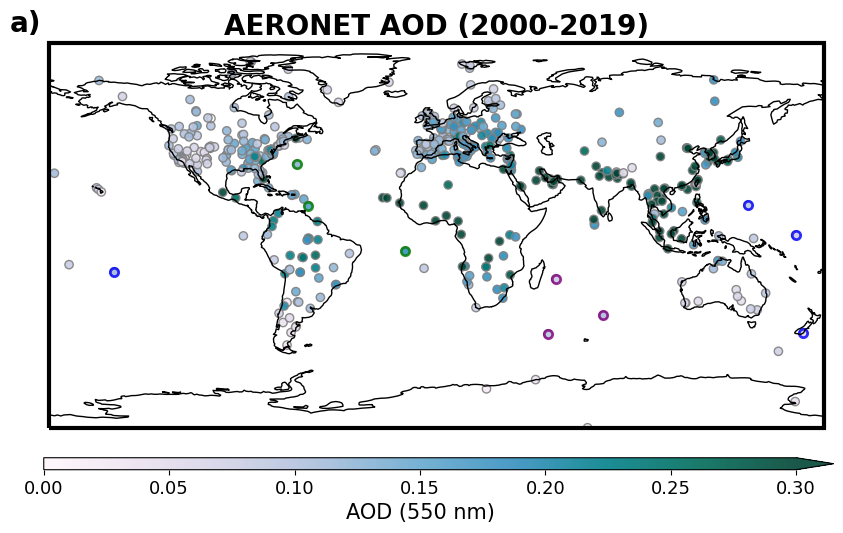

In [218]:
fig, axs = plt.subplots(1,1,figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})


axs.coastlines()
sc = axs.scatter(AERONET_write_climo.lon,AERONET_write_climo.lat,c = AERONET_write_climo.climo_mm.mean("month"), cmap='PuBuGn', alpha=0.9, vmin=0, vmax=0.3,edgecolors='gray')
axs.set_title('AERONET AOD (2000-2019)',fontsize =20,fontweight="bold")
[i.set_linewidth(3) for i in axs.spines.values()];

cax = fig.add_axes([0.12, axs.get_position().y0-0.07, 0.79, 0.02])
cbar = plt.colorbar(sc, cax=cax, orientation='horizontal', extend='max')
cbar.set_label('AOD (550 nm)', fontsize = 15)
cbar.ax.tick_params(labelsize=13) 

sc = axs.scatter(AERONET_write_climo.lon[175],AERONET_write_climo.lat[175],c = AERONET_write_climo.climo_mm.mean("month")[175],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='b', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[318],AERONET_write_climo.lat[318],c = AERONET_write_climo.climo_mm.mean("month")[318],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='b', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[443],AERONET_write_climo.lat[443],c = AERONET_write_climo.climo_mm.mean("month")[443],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='b', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[127],AERONET_write_climo.lat[127],c = AERONET_write_climo.climo_mm.mean("month")[127],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='b', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[385],AERONET_write_climo.lat[385],c = AERONET_write_climo.climo_mm.mean("month")[385],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='purple', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[8],AERONET_write_climo.lat[8],c = AERONET_write_climo.climo_mm.mean("month")[8],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='purple', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[103],AERONET_write_climo.lat[103],c = AERONET_write_climo.climo_mm.mean("month")[103],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='purple', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[42],AERONET_write_climo.lat[42],c = AERONET_write_climo.climo_mm.mean("month")[42],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='g', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[380],AERONET_write_climo.lat[380],c = AERONET_write_climo.climo_mm.mean("month")[380],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='g', linewidth=2)
sc = axs.scatter(AERONET_write_climo.lon[20],AERONET_write_climo.lat[20],c = AERONET_write_climo.climo_mm.mean("month")[20],cmap='PuBuGn', alpha=0.8, vmin=0, vmax=0.3,edgecolors='g', linewidth=2)

#label = ['a)']
#axs.text(-0.05, 1.03, label[0], transform=axs.transAxes, 
#            size=20, weight='bold')

plt.savefig('./fig/aeronet_map.png', bbox_inches="tight")

In [22]:
def taylor_diagram_quarter(obs, models, model_names, title,colors=None):
    """
    Create a quarter-circle Taylor diagram with RMS contours and proper lat/lon handling.
    
    Parameters:
    obs: xarray.DataArray (lat, lon) - Reference observations
    models: list of xarray.DataArray (lat, lon) - Model simulations
    model_names: list of str - Names for each model
    colors: list of str - Colors for each model point
    """
    
    # Convert to numpy arrays and flatten spatial dimensions
    obs_values = obs.values.flatten()
    
    # Calculate statistics for each model
    std_obs = np.nanstd(obs_values)
    corr_coeffs = []
    std_ratios = []
    biases = []
    rms_values = []
    
    for model in models:
        model_values = model.values.flatten()
        
        A = model_values
        B = obs_values
        A = np.where(A == 0, np.nan, A)
        B = np.where(B == 0, np.nan, B)
        
        # Remove NaN values
        mask = ~np.isnan(A) & ~np.isnan(B)
        obs_clean = B[mask]
        model_clean = A[mask]
        
        if len(obs_clean) == 0:
            print(f"Warning: No valid data points for model {model_names[len(corr_coeffs)]}")
            continue
            
        # Calculate statistics
        corr = pearsonr(obs_clean, model_clean)[0]
        std_ratio = np.std(model_clean) / std_obs
        bias = (np.nanmean(A) - np.nanmean(B)) / std_obs
        rms = np.sqrt(np.nanmean((A - B)**2)) / std_obs
        
        corr_coeffs.append(corr)
        std_ratios.append(std_ratio)
        biases.append(bias)
        rms_values.append(rms)
    
    if not corr_coeffs:
        raise ValueError("No valid model data to plot")
    
    # Create quarter-circle plot
    fig = plt.figure(figsize=(5, 6))
    ax = fig.add_subplot(111, projection='polar')
    
    # Set up quarter-circle axes (0-90°)
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    
    # Correlation coefficient labels
    angles = np.linspace(0, 90, 6)
    ax.set_thetagrids(angles, labels=[f"{x:.1f}" for x in np.linspace(1, 0, 6)], fontsize = 10)
    
    # Radial axis (standard deviation ratio)
    rs = np.array([0.5, 1.0, 1.5])
    ax.set_rgrids(rs, angle=22.5, fontsize = 14)
    ax.set_ylim(0, 1.5)
    
    # Add RMS contours
    theta_grid = np.linspace(np.pi/2,0, 100)
    r_grid = np.linspace(0, 1.5, 100)
    THETA, R = np.meshgrid(theta_grid, r_grid)

    theta = np.linspace(0, np.pi/2, 100)
    r = np.ones_like(theta)
    ax.plot(theta, r, 'g-', linewidth=2, alpha=0.7)
    ax.plot(0, 1.0, 'go', markersize=12)
    
    # Define colors for each model
    model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
    
    # Plot each model with annotations
    for i, (std_ratio, corr, bias, rms) in enumerate(zip(std_ratios, corr_coeffs, biases, rms_values)):
        theta = np.arccos(np.clip(corr, -1, 1))
        r = std_ratio
        # Marker properties based on bias
        marker = 's' if bias >= 0 else '^'  # Circle for positive, triangle for negative
        color = model_colors[i % len(model_colors)]
        print(f"Model {i}: corr={corr:.4f} → θ={np.degrees(theta):.2f}°, rms = {rms},r={r:.4f}, bias={bias:.4f},theta = {theta}")
        
        size = 50 + 550 * np.abs(bias)
        ax.scatter(np.degrees(theta)/100, r, s=size, c=color, marker=marker,
                  label=f"{model_names[i]} (bias: {bias:.2f})",
                  edgecolors='black', alpha=0.8, zorder = 10)

    
    # Add title and labels
    ax.set_title(title, pad=8, fontsize=18, fontweight='bold')
    #ax.set_xlabel("Correlation Coefficient")
    ax.set_ylabel("Standard Deviation (normalized)", fontsize = 12)
    
    label = "Correlation"
    label_radius = ax.get_ylim()[1] + 0.1  # Slightly outside the plot radius
    label_angle = np.radians(45)  # Midpoint angle
    ax.text(label_angle, label_radius, label,
        fontsize=12, ha='center', va='bottom',
        rotation=-45, rotation_mode='anchor')
    
    plt.tight_layout()
    return fig, ax


In [26]:
def taylor_diagram_quarter(obs, models, model_names, title,colors=None):
    """
    Create a quarter-circle Taylor diagram with RMS contours and proper lat/lon handling.
    
    Parameters:
    obs: xarray.DataArray (lat, lon) - Reference observations
    models: list of xarray.DataArray (lat, lon) - Model simulations
    model_names: list of str - Names for each model
    colors: list of str - Colors for each model point
    """
    
    # Convert to numpy arrays and flatten spatial dimensions
    obs_values = obs.values.flatten()
    
    # Calculate statistics for each model
    std_obs = np.nanstd(obs_values)
    corr_coeffs = []
    std_ratios = []
    biases = []
    rms_values = []
    
    for model in models:
        model_values = model.values.flatten()
        
        A = model_values
        B = obs_values
        A = np.where(A == 0, np.nan, A)
        B = np.where(B == 0, np.nan, B)
        
        # Remove NaN values
        mask = ~np.isnan(A) & ~np.isnan(B)
        obs_clean = B[mask]
        model_clean = A[mask]
        
        if len(obs_clean) == 0:
            print(f"Warning: No valid data points for model {model_names[len(corr_coeffs)]}")
            continue
            
        # Calculate statistics
        corr = pearsonr(obs_clean, model_clean)[0]
        std_ratio = np.std(model_clean) / std_obs
        bias = (np.nanmean(A-B)) / std_obs
        rms = np.sqrt(np.nanmean((A - B)**2)) / std_obs
        
        corr_coeffs.append(corr)
        std_ratios.append(std_ratio)
        biases.append(bias)
        rms_values.append(rms)
    
    if not corr_coeffs:
        raise ValueError("No valid model data to plot")
    
    markerSize = [50+500 * abs(b) for b in biases]  # Scale bias for visibility
    markerSymbol = ['s' if b >= 0 else '^' for b in biases]  # Circle (positive), Square (negative)
    model_colors = ['#1f77b4', '#ff7f0e', 'tab:purple', '#d62728']
    label = ["Deike", "Gong", "Jaegle", "Martmon"]

    theta = np.arccos(corr_coeffs) # Angle (radians)
    r = std_ratios                   # Radial distance
    x = std_ratios * np.cos(theta)            # Cartesian x
    y = std_ratios * np.sin(theta)            # Cartesian y
    
    fig = plt.figure(figsize=(5, 6))
    
    sm.taylor_diagram(
        np.array(std_ratios),
        np.array(rms_values),
        np.array(corr_coeffs),
        markerLabelColor='black',
        markerSize=0,  # Hide default markers
        colCOR='gray',
        alpha=0.0,
        axismax=1.5,
        #tickRMS= np.linspace(0,1.5, 5),
        #colRMS='m',
        #styleRMS='--',
        styleCOR='-',
        #widthRMS=2,
        titleCOR='on',
        titleRMS='off',
        colRMS = 'none',
        styleRMS =''
    )

    for xi, yi, sz, sym, col, lbl in zip(x, y, markerSize, markerSymbol, model_colors, label):
        plt.scatter(
            xi, yi, 
            s=sz, 
            marker=sym, 
            color=col, 
            label=lbl, 
            edgecolors='black', 
            alpha=0.8, 
            zorder=10
        )

    #plt.plot(theta, r, 'g-', linewidth=2, alpha=0.7)
    plt.plot(1, 0, 'go', markersize=12)

    #legend_handles = [
    #Line2D([0], [0], marker='X', color='w', label=model_names[i],
    #       markerfacecolor=model_colors[i], markeredgecolor='black',
    #       markersize=12, linestyle='None')  # uniform size
    #for i in range(len(model_names))
    #]
    
    legend_handles = [
        Line2D([0], [0], marker='s', color='black', label='Positive bias',
              markerfacecolor='black', markersize=8, linestyle='None'),
        Line2D([0], [0], marker='^', color='black', label='Negative bias',
              markerfacecolor='black', markersize=8, linestyle='None')
    ]
    #ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1.06))
        
    # Add title and labels
    plt.title(title, pad=20, fontsize=18, fontweight='bold')
    #plt.legend(handles=legend_handles,fontsize=10, bbox_to_anchor=(1.1, 1.15))
    plt.plot(np.cos(np.linspace(0, np.pi/2, 300)), np.sin(np.linspace(0, np.pi/2, 300)), color='green', linestyle='-', linewidth=2, label='r = 1')
    
    for i, name in enumerate(label):
        print(f"{name}: std={std_ratios[i]}, rms={rms_values[i]}, corr={corr_coeffs[i]}, bias={biases[i]}")

    plt.tight_layout()
    return fig, ax


Deike: std=0.7009606957435608, rms=0.5591646432876587, corr=0.8662248374885315, bias=-0.188940167427063
Gong: std=0.6983513236045837, rms=0.5422155857086182, corr=0.8562542829452015, bias=-0.047284889966249466
Jaegle: std=0.7238864898681641, rms=0.5239235758781433, corr=0.8641994271823822, bias=-0.040606264024972916
Martmon: std=0.7047172784805298, rms=0.5321505069732666, corr=0.8655797422654635, bias=-0.08084359765052795


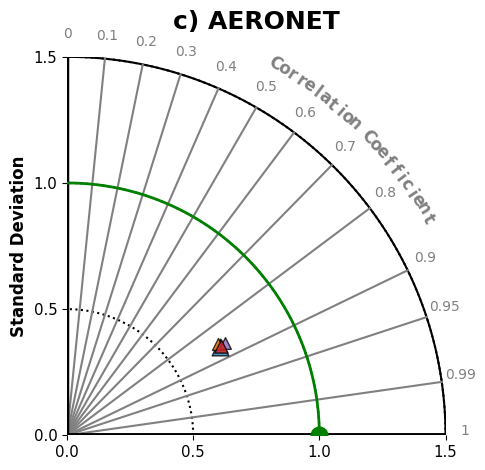

<Figure size 640x480 with 0 Axes>

In [28]:
# Prepare your data
models = [
    AERONET_write_climo.deike.mean("month"),
    AERONET_write_climo.gong.mean("month"),
    AERONET_write_climo.jaegle.mean("month"),
    AERONET_write_climo.martmon.mean("month")
]
model_names = ["Deike", "Gong", "Jaegle", "Martmon"]

# Create and show the plot
try:
    fig, ax = taylor_diagram_quarter(AERONET_write_climo.climo_mm.mean("month"), models, model_names,'c) AERONET')
    plt.show()
except ValueError as e:
    print(f"Error: {e}")

plt.show()
plt.savefig('./fig/aeronet_taylor.png', bbox_inches="tight")

In [35]:
A = AERONET_write_climo.deike.mean("month")
B = AERONET_write_climo.climo_mm.mean("month")
A = np.where(A == 0, np.nan, A)
B = np.where(B == 0, np.nan, B)
        
        # Remove NaN values
mask = ~np.isnan(A) & ~np.isnan(B)
obs_clean = B[mask]
model_clean = A[mask]
           
# Calculate statistics
std_obs = np.nanstd(B)
np.std(model_clean) / std_obs

0.7009607

In [32]:
np.std(model_clean)

0.14532517

In [33]:
std_obs

0.14532517

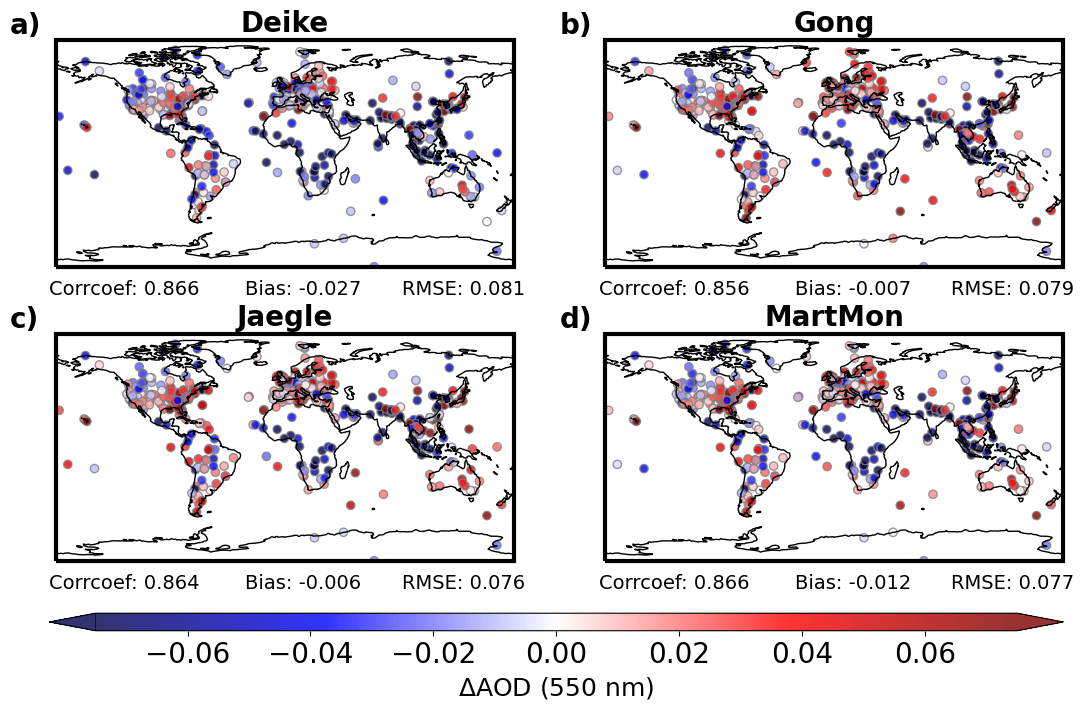

In [219]:
fig, axs = plt.subplots(2,2,figsize=(13, 7), subplot_kw={'projection': ccrs.PlateCarree()})


axs = axs.flatten()
axs[0].coastlines()
sc = axs[0].scatter(AERONET_write_climo.lon,AERONET_write_climo.lat,c = ((AERONET_write_climo.deike.mean("month") - AERONET_write_climo.climo_mm.mean("month"))), cmap='seismic', alpha=0.8, vmin=-0.075, vmax=0.075,edgecolors='gray')

A =  AERONET_write_climo.deike.mean("month").values.flatten()
B =  AERONET_write_climo.climo_mm.mean("month").values.flatten()
A = np.where(A == 0, np.nan, A)
B = np.where(B == 0, np.nan, B)
mask = ~np.isnan(A) & ~np.isnan(B)
A_valid = A[mask]
B_valid = B[mask]
correlation_coefficient, p_value = pearsonr(A_valid, B_valid)
axs[0].text(0.15, -0.12, "Corrcoef: %.3f" % correlation_coefficient, fontsize=14, ha='center', transform=axs[0].transAxes)
axs[0].text(0.54, -0.12, "Bias: %.3f" % round(np.nanmean((A-B)),3), fontsize=14, ha='center', transform=axs[0].transAxes)
axs[0].text(0.89, -0.12, "RMSE: %.3f" % round(np.sqrt(mean_squared_error(B_valid,A_valid)),3), fontsize=14, ha='center', transform=axs[0].transAxes)

axs[0].set_title('Deike',fontsize =20,fontweight="bold")
[i.set_linewidth(3) for i in axs[0].spines.values()];

axs[1].coastlines()
sc = axs[1].scatter(AERONET_write_climo.lon,AERONET_write_climo.lat,c = ((AERONET_write_climo.gong.mean("month") - AERONET_write_climo.climo_mm.mean("month"))), cmap='seismic', alpha=0.8, vmin=-0.075, vmax=0.075,edgecolors='gray')

A =  AERONET_write_climo.gong.mean("month").values.flatten()
B =  AERONET_write_climo.climo_mm.mean("month").values.flatten()
A = np.where(A == 0, np.nan, A)
B = np.where(B == 0, np.nan, B)
mask = ~np.isnan(A) & ~np.isnan(B)
A_valid = A[mask]
B_valid = B[mask]
correlation_coefficient, p_value = pearsonr(A_valid, B_valid)
axs[1].text(0.15, -0.12, "Corrcoef: %.3f" % correlation_coefficient, fontsize=14, ha='center', transform=axs[1].transAxes)
axs[1].text(0.54, -0.12, "Bias: %.3f" % round(np.nanmean((A-B)),3), fontsize=14, ha='center', transform=axs[1].transAxes)
axs[1].text(0.89, -0.12, "RMSE: %.3f" % round(np.sqrt(mean_squared_error(B_valid,A_valid)),3), fontsize=14, ha='center', transform=axs[1].transAxes)

axs[1].set_title('Gong',fontsize =20,fontweight="bold")
[i.set_linewidth(3) for i in axs[1].spines.values()];

axs[2].coastlines()
sc = axs[2].scatter(AERONET_write_climo.lon,AERONET_write_climo.lat,c = ((AERONET_write_climo.jaegle.mean("month") - AERONET_write_climo.climo_mm.mean("month"))), cmap='seismic', alpha=0.8, vmin=-0.075, vmax=0.075,edgecolors='gray')

A =  AERONET_write_climo.jaegle.mean("month").values.flatten()
B =  AERONET_write_climo.climo_mm.mean("month").values.flatten()
A = np.where(A == 0, np.nan, A)
B = np.where(B == 0, np.nan, B)
mask = ~np.isnan(A) & ~np.isnan(B)
A_valid = A[mask]
B_valid = B[mask]
correlation_coefficient, p_value = pearsonr(A_valid, B_valid)
axs[2].text(0.15, -0.12, "Corrcoef: %.3f" % correlation_coefficient, fontsize=14, ha='center', transform=axs[2].transAxes)
axs[2].text(0.54, -0.12, "Bias: %.3f" % round(np.nanmean((A-B)),3), fontsize=14, ha='center', transform=axs[2].transAxes)
axs[2].text(0.89, -0.12, "RMSE: %.3f" % round(np.sqrt(mean_squared_error(B_valid,A_valid)),3), fontsize=14, ha='center', transform=axs[2].transAxes)

axs[2].set_title('Jaegle',fontsize =20,fontweight="bold")
[i.set_linewidth(3) for i in axs[2].spines.values()];

axs[3].coastlines()
sc = axs[3].scatter(AERONET_write_climo.lon,AERONET_write_climo.lat,c = ((AERONET_write_climo.martmon.mean("month") - AERONET_write_climo.climo_mm.mean("month"))), cmap='seismic', alpha=0.8, vmin=-0.075, vmax=0.075,edgecolors='gray')

A =  AERONET_write_climo.martmon.mean("month").values.flatten()
B =  AERONET_write_climo.climo_mm.mean("month").values.flatten()
A = np.where(A == 0, np.nan, A)
B = np.where(B == 0, np.nan, B)
mask = ~np.isnan(A) & ~np.isnan(B)
A_valid = A[mask]
B_valid = B[mask]
correlation_coefficient, p_value = pearsonr(A_valid, B_valid)
axs[3].text(0.15, -0.12, "Corrcoef: %.3f" % correlation_coefficient, fontsize=14, ha='center', transform=axs[3].transAxes)
axs[3].text(0.54, -0.12, "Bias: %.3f" % round(np.nanmean((A-B)),3), fontsize=14, ha='center', transform=axs[3].transAxes)
axs[3].text(0.89, -0.12, "RMSE: %.3f" % round(np.sqrt(mean_squared_error(B_valid,A_valid)),3), fontsize=14, ha='center', transform=axs[3].transAxes)


axs[3].set_title('MartMon',fontsize =20,fontweight="bold")
[i.set_linewidth(3) for i in axs[3].spines.values()];

label = ['a)','b)','c)','d)']
for n, ax in enumerate(axs):
    ax.text(-0.10, 1.03, label[n], transform=ax.transAxes, 
            size=20, weight='bold')

cax = fig.add_axes([0.12, axs[3].get_position().y0-0.1, 0.78, 0.025])
cbar = plt.colorbar(sc, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('$\Delta$AOD (550 nm)', fontsize = 18)
cbar.ax.tick_params(labelsize=20) 

plt.savefig('./fig/aeronet_aod_map.png', bbox_inches="tight")

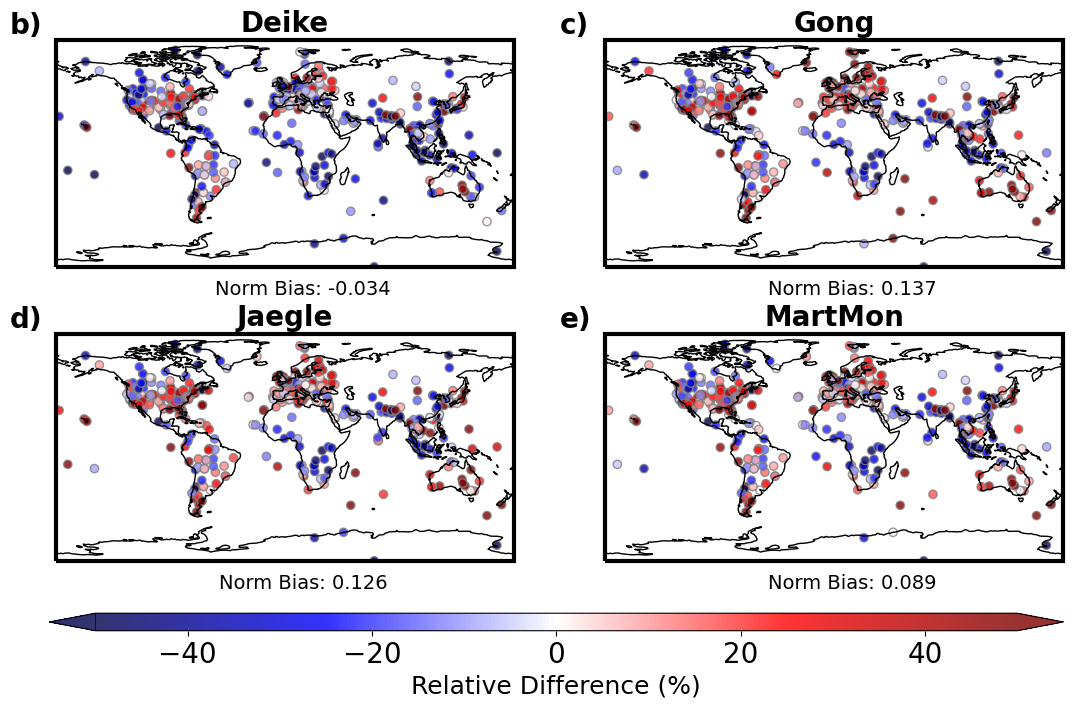

In [153]:
fig, axs = plt.subplots(2,2,figsize=(13, 7), subplot_kw={'projection': ccrs.PlateCarree()})


axs = axs.flatten()
axs[0].coastlines()
sc = axs[0].scatter(AERONET_write_climo.lon,AERONET_write_climo.lat,c = ((AERONET_write_climo.deike.mean("month") - AERONET_write_climo.climo_mm.mean("month")) / AERONET_write_climo.climo_mm.mean("month")) * 100, cmap='seismic', alpha=0.8, vmin=-50, vmax=50,edgecolors='gray')

A =  AERONET_write_climo.deike.mean("month").values.flatten()
B =  AERONET_write_climo.climo_mm.mean("month").values.flatten()
A = np.where(A == 0, np.nan, A)
B = np.where(B == 0, np.nan, B)
mask = ~np.isnan(A) & ~np.isnan(B)
A_valid = A[mask]
B_valid = B[mask]
correlation_coefficient, p_value = pearsonr(A_valid, B_valid)
#axs[0].text(0.15, -0.12, "Corrcoef: %.3f" % correlation_coefficient, fontsize=14, ha='center', transform=axs[0].transAxes)
axs[0].text(0.54, -0.12, "Norm Bias: %.3f" % round(np.nanmean((A-B)/(B)),3), fontsize=14, ha='center', transform=axs[0].transAxes)
#axs[0].text(0.89, -0.12, "RMSE: %.3f" % round(np.sqrt(mean_squared_error(B_valid,A_valid)),3), fontsize=14, ha='center', transform=axs[0].transAxes)

axs[0].set_title('Deike',fontsize =20,fontweight="bold")
[i.set_linewidth(3) for i in axs[0].spines.values()];

axs[1].coastlines()
sc = axs[1].scatter(AERONET_write_climo.lon,AERONET_write_climo.lat,c = ((AERONET_write_climo.gong.mean("month") - AERONET_write_climo.climo_mm.mean("month")) / AERONET_write_climo.climo_mm.mean("month")) * 100, cmap='seismic', alpha=0.8, vmin=-50, vmax=50,edgecolors='gray')

A =  AERONET_write_climo.gong.mean("month").values.flatten()
B =  AERONET_write_climo.climo_mm.mean("month").values.flatten()
A = np.where(A == 0, np.nan, A)
B = np.where(B == 0, np.nan, B)
mask = ~np.isnan(A) & ~np.isnan(B)
A_valid = A[mask]
B_valid = B[mask]
correlation_coefficient, p_value = pearsonr(A_valid, B_valid)
#axs[1].text(0.15, -0.12, "Corrcoef: %.3f" % correlation_coefficient, fontsize=14, ha='center', transform=axs[1].transAxes)
axs[1].text(0.54, -0.12, "Norm Bias: %.3f" % round(np.nanmean((A-B)/(B)),3), fontsize=14, ha='center', transform=axs[1].transAxes)
#axs[1].text(0.89, -0.12, "RMSE: %.3f" % round(np.sqrt(mean_squared_error(B_valid,A_valid)),3), fontsize=14, ha='center', transform=axs[1].transAxes)

axs[1].set_title('Gong',fontsize =20,fontweight="bold")
[i.set_linewidth(3) for i in axs[1].spines.values()];

axs[2].coastlines()
sc = axs[2].scatter(AERONET_write_climo.lon,AERONET_write_climo.lat,c = ((AERONET_write_climo.jaegle.mean("month") - AERONET_write_climo.climo_mm.mean("month")) / AERONET_write_climo.climo_mm.mean("month")) * 100, cmap='seismic', alpha=0.8, vmin=-50, vmax=50,edgecolors='gray')

A =  AERONET_write_climo.jaegle.mean("month").values.flatten()
B =  AERONET_write_climo.climo_mm.mean("month").values.flatten()
A = np.where(A == 0, np.nan, A)
B = np.where(B == 0, np.nan, B)
mask = ~np.isnan(A) & ~np.isnan(B)
A_valid = A[mask]
B_valid = B[mask]
correlation_coefficient, p_value = pearsonr(A_valid, B_valid)
#axs[2].text(0.15, -0.12, "Corrcoef: %.3f" % correlation_coefficient, fontsize=14, ha='center', transform=axs[2].transAxes)
axs[2].text(0.54, -0.12, "Norm Bias: %.3f" % round(np.nanmean((A-B)/(B)),3), fontsize=14, ha='center', transform=axs[2].transAxes)
#axs[2].text(0.89, -0.12, "RMSE: %.3f" % round(np.sqrt(mean_squared_error(B_valid,A_valid)),3), fontsize=14, ha='center', transform=axs[2].transAxes)

axs[2].set_title('Jaegle',fontsize =20,fontweight="bold")
[i.set_linewidth(3) for i in axs[2].spines.values()];

axs[3].coastlines()
sc = axs[3].scatter(AERONET_write_climo.lon,AERONET_write_climo.lat,c = ((AERONET_write_climo.martmon.mean("month") - AERONET_write_climo.climo_mm.mean("month")) / AERONET_write_climo.climo_mm.mean("month")) * 100, cmap='seismic', alpha=0.8, vmin=-50, vmax=50,edgecolors='gray')

A =  AERONET_write_climo.martmon.mean("month").values.flatten()
B =  AERONET_write_climo.climo_mm.mean("month").values.flatten()
A = np.where(A == 0, np.nan, A)
B = np.where(B == 0, np.nan, B)
mask = ~np.isnan(A) & ~np.isnan(B)
A_valid = A[mask]
B_valid = B[mask]
correlation_coefficient, p_value = pearsonr(A_valid, B_valid)
#axs[3].text(0.15, -0.12, "Corrcoef: %.3f" % correlation_coefficient, fontsize=14, ha='center', transform=axs[3].transAxes)
axs[3].text(0.54, -0.12, "Norm Bias: %.3f" % round(np.nanmean((A-B)/(B)),3), fontsize=14, ha='center', transform=axs[3].transAxes)
#axs[3].text(0.89, -0.12, "RMSE: %.3f" % round(np.sqrt(mean_squared_error(B_valid,A_valid)),3), fontsize=14, ha='center', transform=axs[3].transAxes)


axs[3].set_title('MartMon',fontsize =20,fontweight="bold")
[i.set_linewidth(3) for i in axs[3].spines.values()];

label = ['b)','c)','d)','e)']
for n, ax in enumerate(axs):
    ax.text(-0.10, 1.03, label[n], transform=ax.transAxes, 
            size=20, weight='bold')

cax = fig.add_axes([0.12, axs[3].get_position().y0-0.1, 0.78, 0.025])
cbar = plt.colorbar(sc, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('Relative Difference (%)', fontsize = 18)
cbar.ax.tick_params(labelsize=20) 

plt.savefig('./fig/aod_r_map_norm.png', bbox_inches="tight")



In [213]:
observe = AERONET_write_climo.climo_mm[443]
model = AERONET_write_climo.jaegle[443]

stats(observe, model)

Corrcoef= 0.258
RMSE= 0.077
Bias= -0.009


In [49]:
data_arrays = [
    AERONET_write_climo.climo_mm[42],
    AERONET_write_climo.climo_mm[385],
    AERONET_write_climo.climo_mm[380],
    AERONET_write_climo.climo_mm[103],
    AERONET_write_climo.climo_mm[20],
    AERONET_write_climo.climo_mm[8],
    AERONET_write_climo.climo_mm[175],
    AERONET_write_climo.climo_mm[318],
    AERONET_write_climo.climo_mm[127],
    AERONET_write_climo.climo_mm[443],
]
combined = xr.concat(data_arrays, dim='combined')
flat_combined = combined.stack(all_dims=combined.dims).values.flatten()


In [51]:
data_arrays = [
    AERONET_write_climo.deike[42],
    AERONET_write_climo.deike[385],
    AERONET_write_climo.deike[380],
    AERONET_write_climo.deike[103],
    AERONET_write_climo.deike[20],
    AERONET_write_climo.deike[8],
    AERONET_write_climo.deike[175],
    AERONET_write_climo.deike[318],
    AERONET_write_climo.deike[127],
    AERONET_write_climo.deike[443],
]
combined_deike = xr.concat(data_arrays, dim='combined')
flat_combined_deike = combined_deike.stack(all_dims=combined_deike.dims).values.flatten()

data_arrays = [
    AERONET_write_climo.gong[42],
    AERONET_write_climo.gong[385],
    AERONET_write_climo.gong[380],
    AERONET_write_climo.gong[103],
    AERONET_write_climo.gong[20],
    AERONET_write_climo.gong[8],
    AERONET_write_climo.gong[175],
    AERONET_write_climo.gong[318],
    AERONET_write_climo.gong[127],
    AERONET_write_climo.gong[443],
]
combined_gong = xr.concat(data_arrays, dim='combined')
flat_combined_gong = combined_gong.stack(all_dims=combined_gong.dims).values.flatten()

data_arrays = [
    AERONET_write_climo.jaegle[42],
    AERONET_write_climo.jaegle[385],
    AERONET_write_climo.jaegle[380],
    AERONET_write_climo.jaegle[103],
    AERONET_write_climo.jaegle[20],
    AERONET_write_climo.jaegle[8],
    AERONET_write_climo.jaegle[175],
    AERONET_write_climo.jaegle[318],
    AERONET_write_climo.jaegle[127],
    AERONET_write_climo.jaegle[443],
]
combined_jaegle = xr.concat(data_arrays, dim='combined')
flat_combined_jaegle = combined_jaegle.stack(all_dims=combined_jaegle.dims).values.flatten()

data_arrays = [
    AERONET_write_climo.martmon[42],
    AERONET_write_climo.martmon[385],
    AERONET_write_climo.martmon[380],
    AERONET_write_climo.martmon[103],
    AERONET_write_climo.martmon[20],
    AERONET_write_climo.martmon[8],
    AERONET_write_climo.martmon[175],
    AERONET_write_climo.martmon[318],
    AERONET_write_climo.martmon[127],
    AERONET_write_climo.martmon[443],
]
combined_martmon = xr.concat(data_arrays, dim='combined')
flat_combined_martmon = combined_martmon.stack(all_dims=combined_martmon.dims).values.flatten()


In [54]:
stats(flat_combined, flat_combined_deike)

Corrcoef= 0.66
RMSE= 0.055
Bias= -0.036


In [55]:
stats(flat_combined, flat_combined_jaegle)

Corrcoef= 0.534
RMSE= 0.059
Bias= 0.032


In [56]:
stats(flat_combined, flat_combined_gong)

Corrcoef= 0.369
RMSE= 0.067
Bias= 0.024


In [57]:
stats(flat_combined, flat_combined_martmon)

Corrcoef= 0.569
RMSE= 0.048
Bias= 0.01


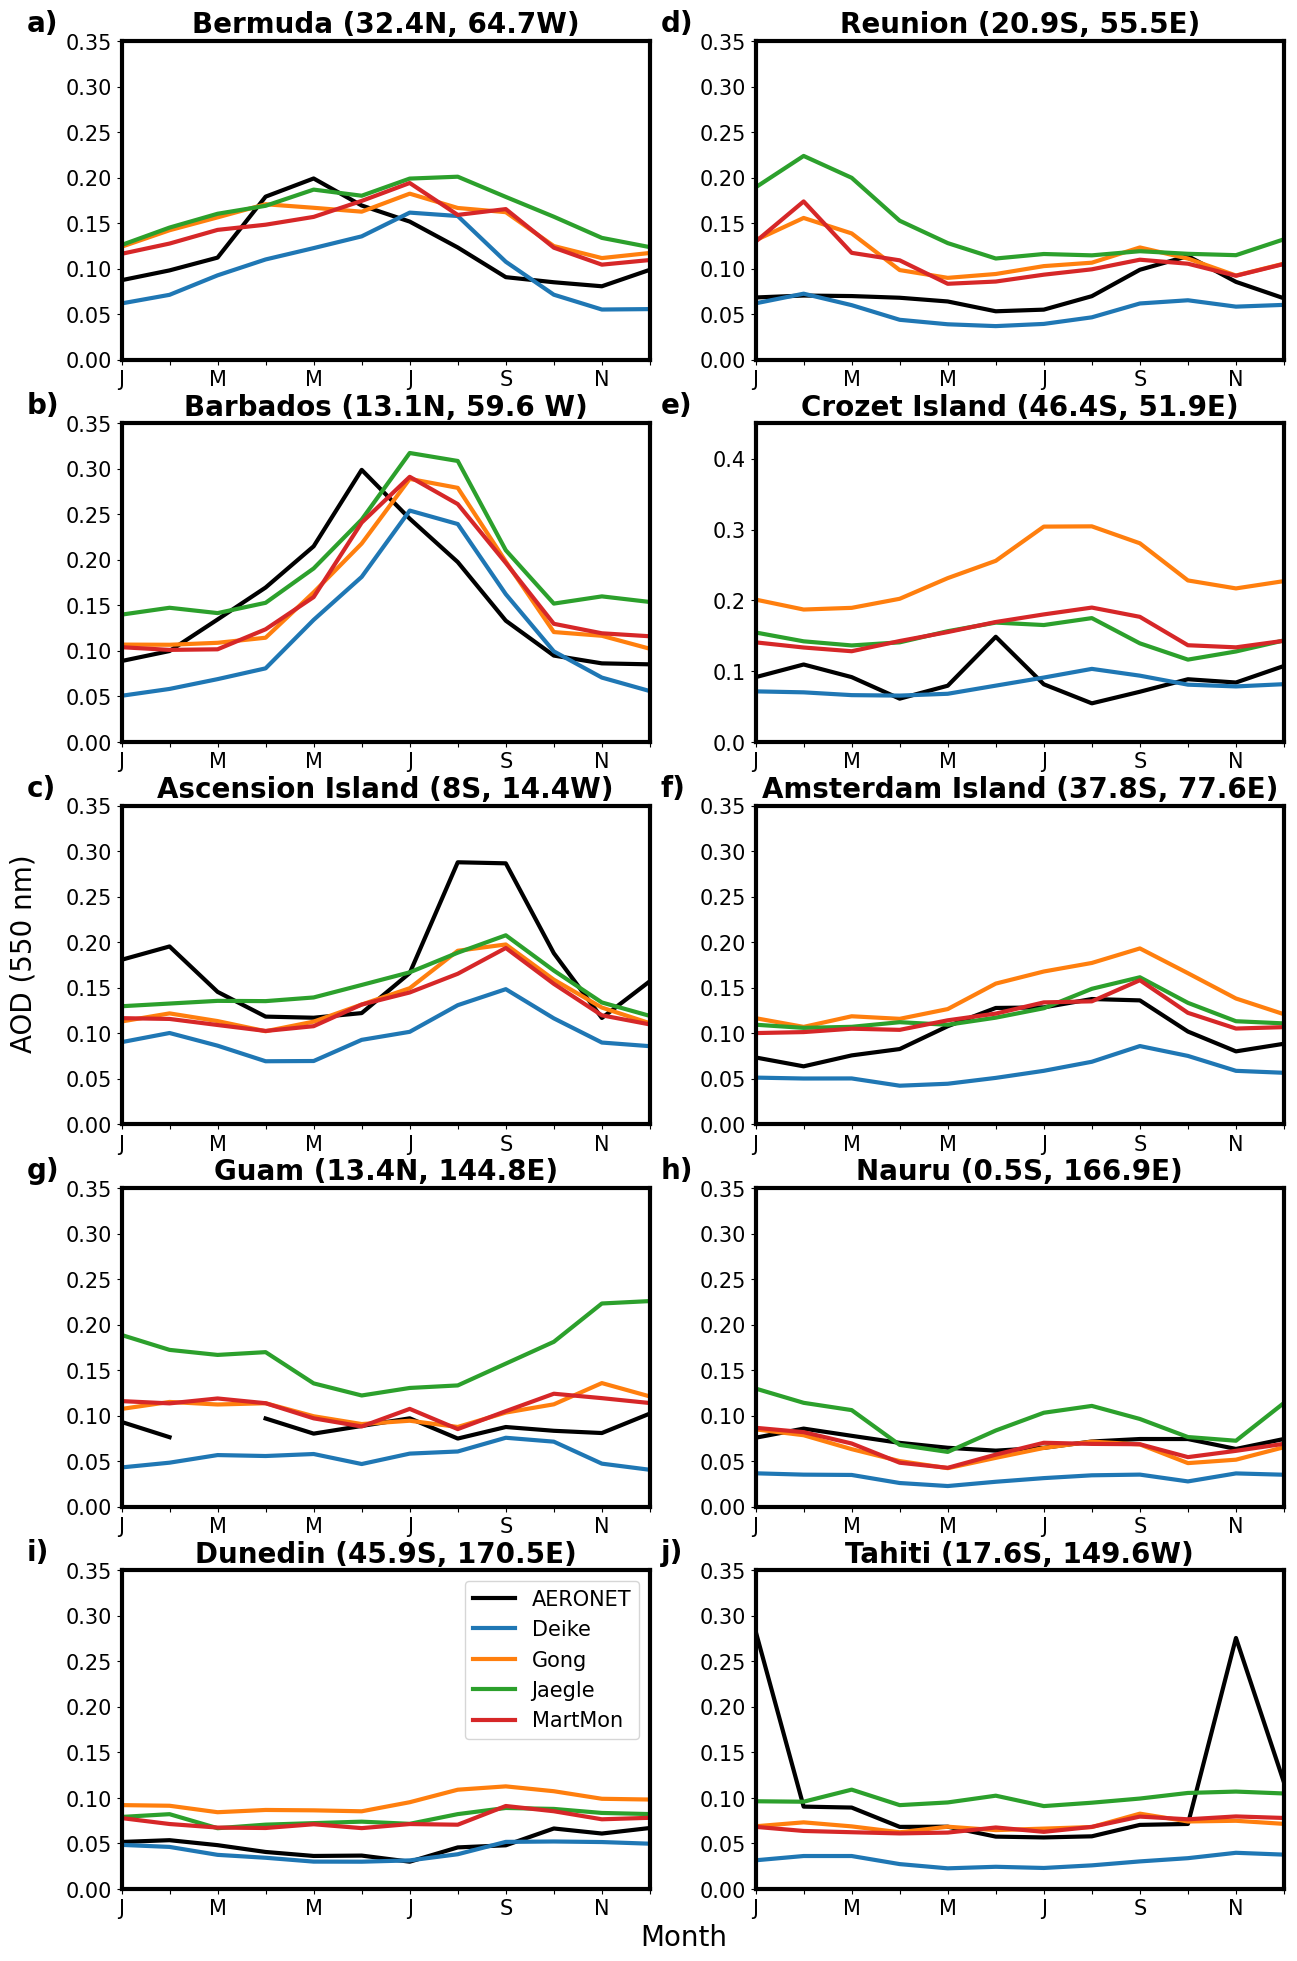

In [41]:
month = np.arange(1, 13)
xtickname = ['J', ' ', 'M', ' ', 'M', ' ', 'J', ' ', 'S', ' ', 'N', ' '] #if count > 0 else [' '] * 12


fig, axs = plt.subplots(5,2,figsize=(15, 24))

axs = axs.flatten()

axs[0].set_title('Bermuda (32.4N, 64.7W)',fontsize =20,fontweight="bold")
axs[0].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[42],linewidth = 3,color = 'k',label='AERONET')
axs[0].plot(np.linspace(1,12,12),AERONET_write_climo.deike[42],linewidth = 3,label='Deike')
axs[0].plot(np.linspace(1,12,12),AERONET_write_climo.gong[42],linewidth = 3, label='Gong')
axs[0].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[42],linewidth = 3, label='Jaegle')
axs[0].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[42],linewidth = 3, label='MartMon')

axs[0].set_xticks(month)
axs[0].set_xticklabels(xtickname);
axs[0].set_xlim(1, 12)
axs[0].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[0].spines.values()];
axs[0].set_ylim([0,0.35]);

axs[1].set_title('Reunion (20.9S, 55.5E)',fontsize =20,fontweight="bold")
axs[1].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[385],linewidth = 3,color = 'k',label='AERONET')
axs[1].plot(np.linspace(1,12,12),AERONET_write_climo.deike[385],linewidth = 3,label='Deike')
axs[1].plot(np.linspace(1,12,12),AERONET_write_climo.gong[385],linewidth = 3, label='Gong')
axs[1].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[385],linewidth = 3, label='Jaegle')
axs[1].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[385],linewidth = 3, label='MartMon')

axs[1].set_xticks(month)
axs[1].set_xticklabels(xtickname);
axs[1].set_xlim(1, 12)
axs[1].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[1].spines.values()];
axs[1].set_ylim([0,0.35]);

axs[2].set_title('Barbados (13.1N, 59.6 W)',fontsize =20,fontweight="bold")
axs[2].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[380],linewidth = 3,color = 'k',label='AERONET')
axs[2].plot(np.linspace(1,12,12),AERONET_write_climo.deike[380],linewidth = 3,label='Deike')
axs[2].plot(np.linspace(1,12,12),AERONET_write_climo.gong[380],linewidth = 3, label='Gong')
axs[2].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[380],linewidth = 3, label='Jaegle')
axs[2].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[380],linewidth = 3, label='MartMon')

axs[2].set_xticks(month)
axs[2].set_xticklabels(xtickname);
axs[2].set_xlim(1, 12)
axs[2].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[2].spines.values()];
axs[2].set_ylim([0,0.35]);

axs[3].set_title('Crozet Island (46.4S, 51.9E)',fontsize =20,fontweight="bold")
axs[3].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[103],linewidth = 3,color = 'k',label='AERONET')
axs[3].plot(np.linspace(1,12,12),AERONET_write_climo.deike[103],linewidth = 3,label='Deike')
axs[3].plot(np.linspace(1,12,12),AERONET_write_climo.gong[103],linewidth = 3, label='Gong')
axs[3].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[103],linewidth = 3, label='Jaegle')
axs[3].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[103],linewidth = 3, label='MartMon')

axs[3].set_xticks(month)
axs[3].set_xticklabels(xtickname);
axs[3].set_xlim(1, 12)
axs[3].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[3].spines.values()];
axs[3].set_ylim([0,0.45]);

axs[4].set_title('Ascension Island (8S, 14.4W)',fontsize =20,fontweight="bold")
axs[4].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[20],linewidth = 3,color = 'k',label='AERONET')
axs[4].plot(np.linspace(1,12,12),AERONET_write_climo.deike[20],linewidth = 3,label='Deike')
axs[4].plot(np.linspace(1,12,12),AERONET_write_climo.gong[20],linewidth = 3, label='Gong')
axs[4].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[20],linewidth = 3, label='Jaegle')
axs[4].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[20],linewidth = 3, label='MartMon')

axs[4].set_xticks(month)
axs[4].set_xticklabels(xtickname);
axs[4].set_xlim(1, 12)
axs[4].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[4].spines.values()];
axs[4].set_ylim([0,0.35]);

axs[5].set_title('Amsterdam Island (37.8S, 77.6E)',fontsize =20,fontweight="bold")
axs[5].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[8],linewidth = 3,color = 'k',label='AERONET')
axs[5].plot(np.linspace(1,12,12),AERONET_write_climo.deike[8],linewidth = 3,label='Deike')
axs[5].plot(np.linspace(1,12,12),AERONET_write_climo.gong[8],linewidth = 3, label='Gong')
axs[5].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[8],linewidth = 3, label='Jaegle')
axs[5].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[8],linewidth = 3, label='MartMon')

axs[5].set_xticks(month)
axs[5].set_xticklabels(xtickname);
axs[5].set_xlim(1, 12)
axs[5].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[5].spines.values()];
axs[5].set_ylim([0,0.35]);

axs[6].set_title('Guam (13.4N, 144.8E)',fontsize =20,fontweight="bold")

axs[6].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[175],linewidth = 3,color = 'k',label='AERONET')
axs[6].plot(np.linspace(1,12,12),AERONET_write_climo.deike[175],linewidth = 3,label='Deike')
axs[6].plot(np.linspace(1,12,12),AERONET_write_climo.gong[175],linewidth = 3, label='Gong')
axs[6].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[175],linewidth = 3, label='Jaegle')
axs[6].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[175],linewidth = 3, label='Martmon')

#axs[0].legend(fontsize=15)
#xtickname = ['J', ' ', 'M', '', 'M', '', 'J', '', 'S', '', 'N',''] #if count > 0 else [' '] * 12;
#month = np.arange(0, 12)

axs[6].set_xticks(month)
axs[6].set_xticklabels(xtickname);
axs[6].set_xlim(1, 12)
axs[6].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[6].spines.values()];
#axs[0].set_ylabel('AOD [550 nm]', fontsize=15);
axs[6].set_ylim([0,0.35]);

axs[7].set_title('Nauru (0.5S, 166.9E)',fontsize =20,fontweight="bold")
axs[7].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[318],linewidth = 3,color = 'k',label='AERONET')
axs[7].plot(np.linspace(1,12,12),AERONET_write_climo.deike[318],linewidth = 3,label='Deike')
axs[7].plot(np.linspace(1,12,12),AERONET_write_climo.gong[318],linewidth = 3, label='Gong')
axs[7].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[318],linewidth = 3, label='Jaegle')
axs[7].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[318],linewidth = 3, label='MartMon')

axs[7].set_xticks(month)
axs[7].set_xticklabels(xtickname);
axs[7].set_xlim(1, 12)
axs[7].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[7].spines.values()];
axs[7].set_ylim([0,0.35]);

axs[8].set_title('Dunedin (45.9S, 170.5E)',fontsize =20,fontweight="bold")
axs[8].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[127],linewidth = 3,color = 'k',label='AERONET')
axs[8].plot(np.linspace(1,12,12),AERONET_write_climo.deike[127],linewidth = 3,label='Deike')
axs[8].plot(np.linspace(1,12,12),AERONET_write_climo.gong[127],linewidth = 3, label='Gong')
axs[8].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[127],linewidth = 3, label='Jaegle')
axs[8].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[127],linewidth = 3, label='MartMon')

axs[8].set_xticks(month)
axs[8].set_xticklabels(xtickname);
axs[8].set_xlim(1, 12)
axs[8].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[8].spines.values()];
axs[8].set_ylim([0,0.35]);
axs[8].legend(fontsize=15)

axs[9].set_title('Tahiti (17.6S, 149.6W)',fontsize =20,fontweight="bold")
axs[9].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[443],linewidth = 3,color = 'k',label='AERONET')
axs[9].plot(np.linspace(1,12,12),AERONET_write_climo.deike[443],linewidth = 3,label='Deike')
axs[9].plot(np.linspace(1,12,12),AERONET_write_climo.gong[443],linewidth = 3, label='Gong')
axs[9].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[443],linewidth = 3, label='Jaegle')
axs[9].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[443],linewidth = 3, label='MartMon')

axs[9].set_xticks(month)
axs[9].set_xticklabels(xtickname);
axs[9].set_xlim(1, 12)
axs[9].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[9].spines.values()];
axs[9].set_ylim([0,0.35]);

label = ['a)','d)','b)','e)','c)','f)','g)','h)','i)','j)']
for n, ax in enumerate(axs):
    ax.text(-0.18, 1.03, label[n], transform=ax.transAxes, 
            size=20, weight='bold')

fig.text(0.06, 0.5, 'AOD (550 nm)', va='center', ha='center', rotation='vertical', fontsize=20)
fig.text(0.5, 0.09, 'Month', va='center', ha='center', rotation='horizontal', fontsize=20)

plt.savefig('./fig/aod_sites.png', bbox_inches="tight")

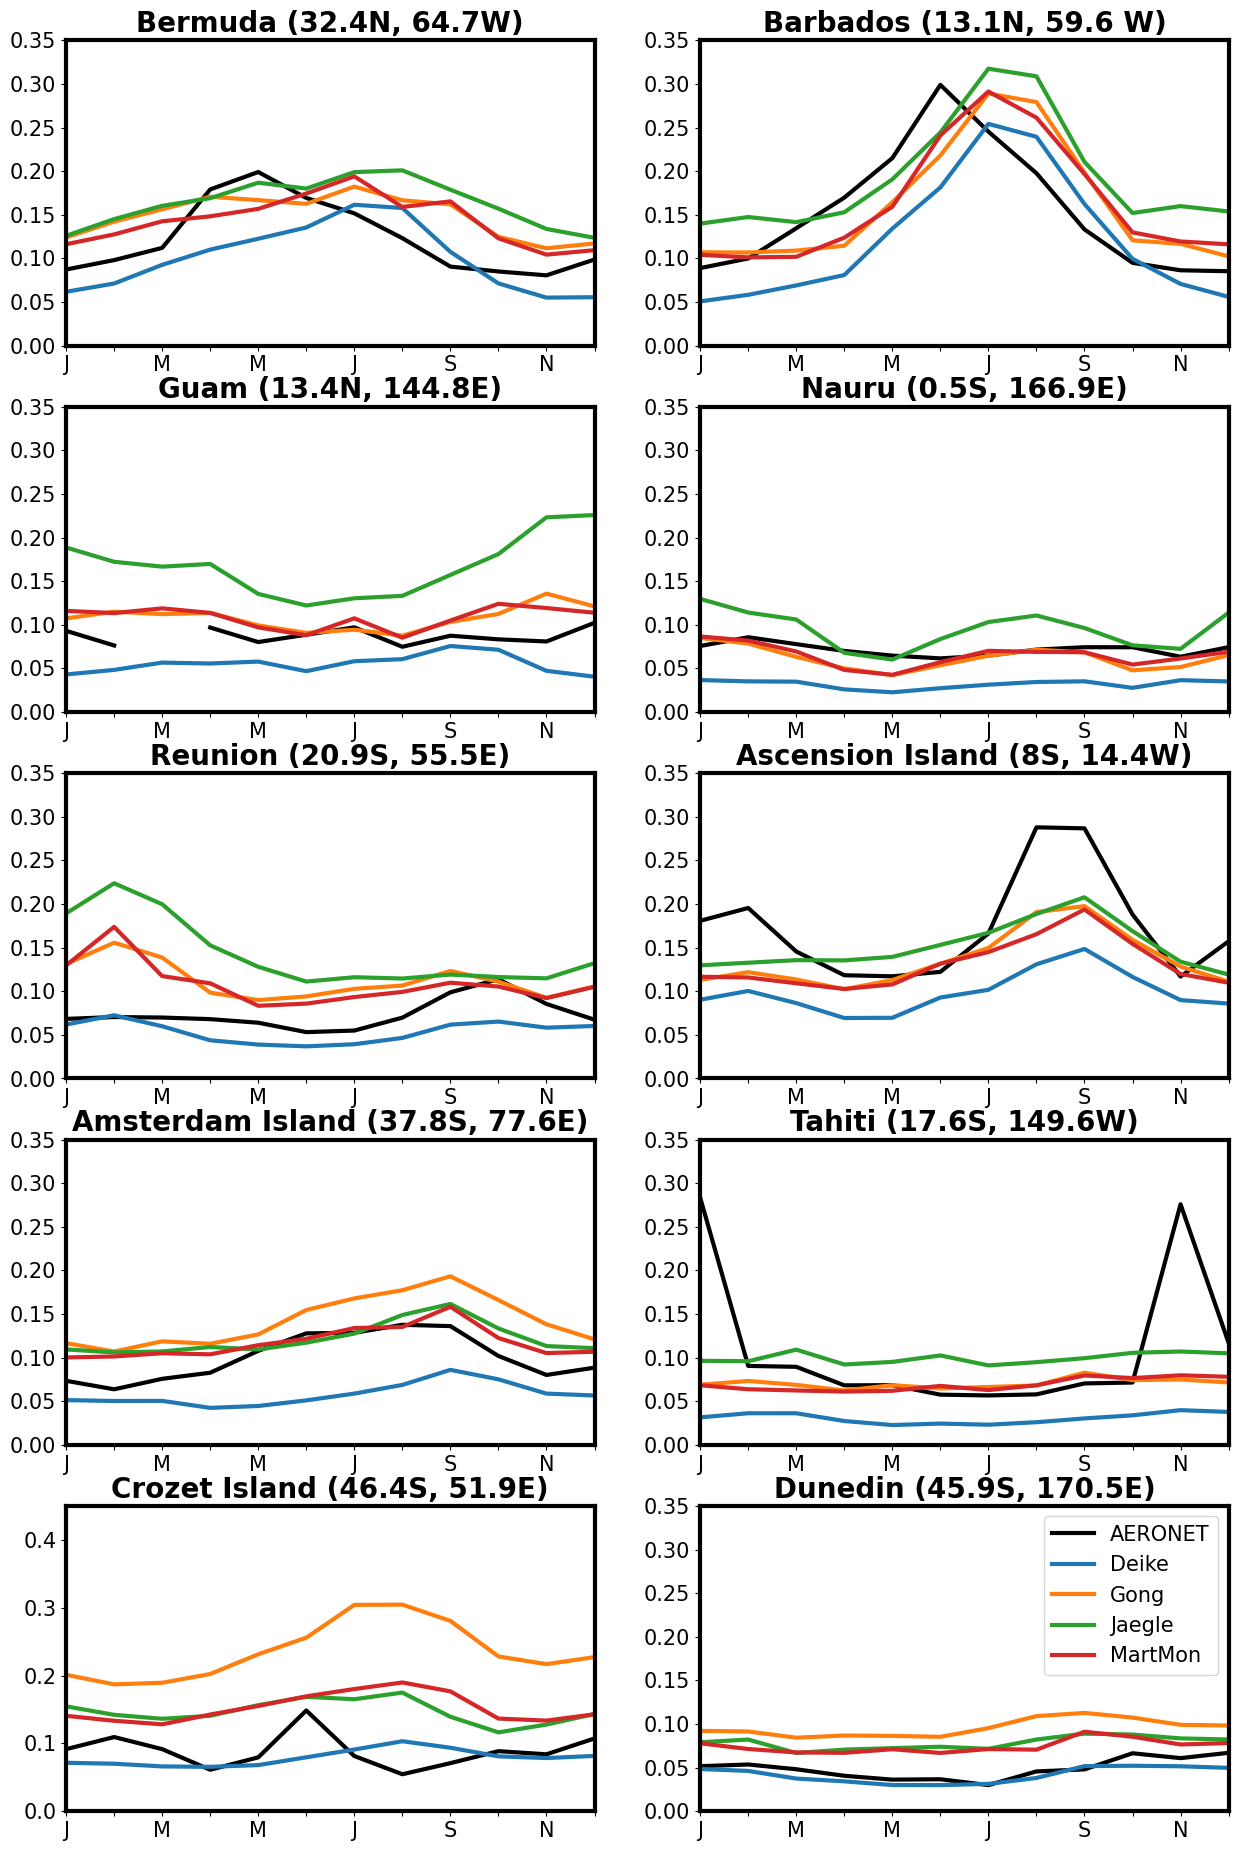

In [43]:
month = np.arange(1, 13)
xtickname = ['J', ' ', 'M', ' ', 'M', ' ', 'J', ' ', 'S', ' ', 'N', ' '] #if count > 0 else [' '] * 12


fig, axs = plt.subplots(5,2,figsize=(15, 23))

axs = axs.flatten()

axs[0].set_title('Bermuda (32.4N, 64.7W)',fontsize =20,fontweight="bold")
axs[0].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[42],linewidth = 3,color = 'k',label='AERONET')
axs[0].plot(np.linspace(1,12,12),AERONET_write_climo.deike[42],linewidth = 3,label='Deike')
axs[0].plot(np.linspace(1,12,12),AERONET_write_climo.gong[42],linewidth = 3, label='Gong')
axs[0].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[42],linewidth = 3, label='Jaegle')
axs[0].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[42],linewidth = 3, label='MartMon')

axs[0].set_xticks(month)
axs[0].set_xticklabels(xtickname);
axs[0].set_xlim(1, 12)
axs[0].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[0].spines.values()];
axs[0].set_ylim([0,0.35]);

axs[1].set_title('Barbados (13.1N, 59.6 W)',fontsize =20,fontweight="bold")
axs[1].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[380],linewidth = 3,color = 'k',label='AERONET')
axs[1].plot(np.linspace(1,12,12),AERONET_write_climo.deike[380],linewidth = 3,label='Deike')
axs[1].plot(np.linspace(1,12,12),AERONET_write_climo.gong[380],linewidth = 3, label='Gong')
axs[1].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[380],linewidth = 3, label='Jaegle')
axs[1].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[380],linewidth = 3, label='MartMon')

axs[1].set_xticks(month)
axs[1].set_xticklabels(xtickname);
axs[1].set_xlim(1, 12)
axs[1].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[1].spines.values()];
axs[1].set_ylim([0,0.35]);

axs[2].set_title('Guam (13.4N, 144.8E)',fontsize =20,fontweight="bold")

axs[2].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[175],linewidth = 3,color = 'k',label='AERONET')
axs[2].plot(np.linspace(1,12,12),AERONET_write_climo.deike[175],linewidth = 3,label='Deike')
axs[2].plot(np.linspace(1,12,12),AERONET_write_climo.gong[175],linewidth = 3, label='Gong')
axs[2].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[175],linewidth = 3, label='Jaegle')
axs[2].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[175],linewidth = 3, label='Martmon')

#axs[0].legend(fontsize=15)
#xtickname = ['J', ' ', 'M', '', 'M', '', 'J', '', 'S', '', 'N',''] #if count > 0 else [' '] * 12;
#month = np.arange(0, 12)

axs[2].set_xticks(month)
axs[2].set_xticklabels(xtickname);
axs[2].set_xlim(1, 12)
axs[2].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[2].spines.values()];
#axs[0].set_ylabel('AOD [550 nm]', fontsize=15);
axs[2].set_ylim([0,0.35]);

axs[3].set_title('Nauru (0.5S, 166.9E)',fontsize =20,fontweight="bold")
axs[3].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[318],linewidth = 3,color = 'k',label='AERONET')
axs[3].plot(np.linspace(1,12,12),AERONET_write_climo.deike[318],linewidth = 3,label='Deike')
axs[3].plot(np.linspace(1,12,12),AERONET_write_climo.gong[318],linewidth = 3, label='Gong')
axs[3].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[318],linewidth = 3, label='Jaegle')
axs[3].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[318],linewidth = 3, label='MartMon')

axs[3].set_xticks(month)
axs[3].set_xticklabels(xtickname);
axs[3].set_xlim(1, 12)
axs[3].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[3].spines.values()];
axs[3].set_ylim([0,0.35]);

axs[4].set_title('Reunion (20.9S, 55.5E)',fontsize =20,fontweight="bold")
axs[4].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[385],linewidth = 3,color = 'k',label='AERONET')
axs[4].plot(np.linspace(1,12,12),AERONET_write_climo.deike[385],linewidth = 3,label='Deike')
axs[4].plot(np.linspace(1,12,12),AERONET_write_climo.gong[385],linewidth = 3, label='Gong')
axs[4].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[385],linewidth = 3, label='Jaegle')
axs[4].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[385],linewidth = 3, label='MartMon')

axs[4].set_xticks(month)
axs[4].set_xticklabels(xtickname);
axs[4].set_xlim(1, 12)
axs[4].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[4].spines.values()];
axs[4].set_ylim([0,0.35]);

axs[5].set_title('Ascension Island (8S, 14.4W)',fontsize =20,fontweight="bold")
axs[5].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[20],linewidth = 3,color = 'k',label='AERONET')
axs[5].plot(np.linspace(1,12,12),AERONET_write_climo.deike[20],linewidth = 3,label='Deike')
axs[5].plot(np.linspace(1,12,12),AERONET_write_climo.gong[20],linewidth = 3, label='Gong')
axs[5].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[20],linewidth = 3, label='Jaegle')
axs[5].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[20],linewidth = 3, label='MartMon')

axs[5].set_xticks(month)
axs[5].set_xticklabels(xtickname);
axs[5].set_xlim(1, 12)
axs[5].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[5].spines.values()];
axs[5].set_ylim([0,0.35]);

axs[6].set_title('Amsterdam Island (37.8S, 77.6E)',fontsize =20,fontweight="bold")
axs[6].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[8],linewidth = 3,color = 'k',label='AERONET')
axs[6].plot(np.linspace(1,12,12),AERONET_write_climo.deike[8],linewidth = 3,label='Deike')
axs[6].plot(np.linspace(1,12,12),AERONET_write_climo.gong[8],linewidth = 3, label='Gong')
axs[6].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[8],linewidth = 3, label='Jaegle')
axs[6].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[8],linewidth = 3, label='MartMon')

axs[6].set_xticks(month)
axs[6].set_xticklabels(xtickname);
axs[6].set_xlim(1, 12)
axs[6].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[6].spines.values()];
axs[6].set_ylim([0,0.35]);

axs[7].set_title('Tahiti (17.6S, 149.6W)',fontsize =20,fontweight="bold")
axs[7].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[443],linewidth = 3,color = 'k',label='AERONET')
axs[7].plot(np.linspace(1,12,12),AERONET_write_climo.deike[443],linewidth = 3,label='Deike')
axs[7].plot(np.linspace(1,12,12),AERONET_write_climo.gong[443],linewidth = 3, label='Gong')
axs[7].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[443],linewidth = 3, label='Jaegle')
axs[7].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[443],linewidth = 3, label='MartMon')

axs[7].set_xticks(month)
axs[7].set_xticklabels(xtickname);
axs[7].set_xlim(1, 12)
axs[7].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[7].spines.values()];
axs[7].set_ylim([0,0.35]);

axs[8].set_title('Crozet Island (46.4S, 51.9E)',fontsize =20,fontweight="bold")
axs[8].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[103],linewidth = 3,color = 'k',label='AERONET')
axs[8].plot(np.linspace(1,12,12),AERONET_write_climo.deike[103],linewidth = 3,label='Deike')
axs[8].plot(np.linspace(1,12,12),AERONET_write_climo.gong[103],linewidth = 3, label='Gong')
axs[8].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[103],linewidth = 3, label='Jaegle')
axs[8].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[103],linewidth = 3, label='MartMon')

axs[8].set_xticks(month)
axs[8].set_xticklabels(xtickname);
axs[8].set_xlim(1, 12)
axs[8].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[8].spines.values()];
axs[8].set_ylim([0,0.45]);

axs[9].set_title('Dunedin (45.9S, 170.5E)',fontsize =20,fontweight="bold")
axs[9].plot(np.linspace(1,12,12),AERONET_write_climo.climo_mm[127],linewidth = 3,color = 'k',label='AERONET')
axs[9].plot(np.linspace(1,12,12),AERONET_write_climo.deike[127],linewidth = 3,label='Deike')
axs[9].plot(np.linspace(1,12,12),AERONET_write_climo.gong[127],linewidth = 3, label='Gong')
axs[9].plot(np.linspace(1,12,12),AERONET_write_climo.jaegle[127],linewidth = 3, label='Jaegle')
axs[9].plot(np.linspace(1,12,12),AERONET_write_climo.martmon[127],linewidth = 3, label='MartMon')

axs[9].set_xticks(month)
axs[9].set_xticklabels(xtickname);
axs[9].set_xlim(1, 12)
axs[9].tick_params(axis='both', which='major', labelsize=15)
[i.set_linewidth(3) for i in axs[9].spines.values()];
axs[9].set_ylim([0,0.35]);
axs[9].legend(fontsize=15)


#fig.text(0.06, 0.5, 'AOD (550 nm)', va='center', ha='center', rotation='vertical', fontsize=20)


#label = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']
#for n, ax in enumerate(axs):
#    ax.text(-0.18, 1.03, label[n], transform=ax.transAxes, 
#            size=20, weight='bold')
    
plt.savefig('./fig/aod_sites.png', bbox_inches="tight")

In [159]:
observe = np.concatenate([AERONET_write_climo.climo_mm[42],
                   AERONET_write_climo.climo_mm[380],
                   AERONET_write_climo.climo_mm[20]],axis=0)
model = np.concatenate([AERONET_write_climo.martmon[42],
                 AERONET_write_climo.martmon[380],
                 AERONET_write_climo.martmon[20]
                 ],axis=0)



In [289]:
#Corrcoef
round(np.corrcoef(observe,model)[0,1],3)

0.641

In [290]:
#RMSE
round(np.sqrt(mean_squared_error(observe,model)),3)


0.047

In [291]:
#Bias
round(np.nanmean((model-observe)/(observe)),3)


0.045

In [53]:
def stats(observe, model):
    print('Corrcoef=',round(np.corrcoef(observe[~np.isnan(observe)],model[~np.isnan(observe)])[0,1],3))
    print('RMSE=', round(np.sqrt(mean_squared_error(observe[~np.isnan(observe)],model[~np.isnan(observe)])),3))
    print('Bias=', round(np.nanmean((model[~np.isnan(observe)]-observe[~np.isnan(observe)])),3))


In [167]:
stats(observe, model)

Corrcoef= 0.641
RMSE= 0.047
Bias= -0.005


In [196]:
observe[~np.isnan(observe)]

<xarray.DataArray 'climo_mm' (month: 11)>
array([0.093069  , 0.07631   , 0.0968555 , 0.08022167, 0.088647  ,
       0.097044  , 0.074812  , 0.0874855 , 0.083334  , 0.08087251,
       0.10226201], dtype=float32)
Coordinates:
  * month    (month) int32 1 2 4 5 6 7 8 9 10 11 12
    stat     int64 175